In [2]:

# Core data manipulation libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array functionality
import re  # For regular expressions (text pattern matching)

# NLTK (Natural Language Toolkit) imports for text processing
import nltk
from nltk.tokenize import word_tokenize  # Split text into individual words
from nltk.corpus import stopwords  # Common words to filter out (e.g., 'the', 'a', 'is')
from nltk.stem import PorterStemmer  # Reduce words to their root form (stem)
from nltk.stem import WordNetLemmatizer  # Reduce words to their dictionary form (lemma)

# Scikit-learn Pipeline for chaining preprocessing and model steps
from sklearn.pipeline import Pipeline

# Scikit-learn feature extraction tools for text vectorization
from sklearn.feature_extraction.text import CountVectorizer  # Convert text to word count vectors
from sklearn.feature_extraction.text import TfidfTransformer  # Transform counts to TF-IDF representation
from sklearn.feature_extraction.text import TfidfVectorizer  # Combined CountVectorizer + TfidfTransformer

# Scikit-learn classification models
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier for text
from sklearn.svm import SVC  # Support Vector Machine classifier

# Scikit-learn model selection and validation tools
from sklearn.model_selection import StratifiedKFold  # Stratified K-fold cross-validation (maintains class distribution)
from sklearn.model_selection import KFold  # Standard K-fold cross-validation
from sklearn.model_selection import train_test_split  # Split data into train/test sets

# Scikit-learn evaluation metrics
from sklearn.metrics import accuracy_score  # Calculate accuracy percentage
from sklearn.metrics import precision_score  # Calculate precision (true positives / predicted positives)
from sklearn.metrics import recall_score  # Calculate recall (true positives / actual positives)
from sklearn.metrics import f1_score  # Calculate F1 score (harmonic mean of precision and recall)
from sklearn.metrics import classification_report  # Generate comprehensive classification metrics

# Scikit-learn base classes for creating custom transformers
from sklearn.base import BaseEstimator, TransformerMixin  # Base classes for custom pipeline components

# Gensim for word embeddings
from gensim.models import Word2Vec  # Train and use Word2Vec word embedding models

# TensorFlow/Keras for deep learning models
from tensorflow.keras.models import Sequential  # Sequential neural network model
from tensorflow.keras.layers import LSTM, Dense, Embedding  # Neural network layer types
from tensorflow.keras.preprocessing.text import Tokenizer  # Convert text to sequences of integers
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Pad sequences to uniform length

# Download required NLTK data files
nltk.download('punkt')  # Tokenizer models for sentence and word splitting
nltk.download('stopwords')  # Lists of common stopwords in multiple languages
nltk.download('wordnet')
# Ignore warnings to make life easier
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lapos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lapos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lapos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df_train = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/train-00000-of-00001.parquet")
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/test-00000-of-00001.parquet")
df_unsupervised = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/unsupervised-00000-of-00001.parquet")

In [4]:
df_train.shape

(25000, 2)

In [5]:
df_test.shape

(25000, 2)

In [6]:
df_train.columns


Index(['text', 'label'], dtype='object')

In [7]:
df_test.columns


Index(['text', 'label'], dtype='object')

In [8]:
df_train['label'].unique()

array([0, 1])

In [9]:
df_test['label'].unique()

array([0, 1])

In [10]:
df_train['text'].sample(10)

19104    Methinks the best screen version of Quo Vadis?...
15621    I haven't liked many TV shows post 1990, but T...
12250    Beast Wars is a show that is over-hyped, overp...
1618     This was a waste of 75 minutes of my life. The...
20025    This is the best of Shelley Duvall's high-qual...
17885    With part reconstruction and part direct shoot...
7398     Perhaps not my genre but plot was horrible as ...
21814    Jean Harlow and Clark Gable were a great on sc...
8290     This "film" attempts to follow the genre of lo...
16354    I saw this movie on TV when it came out, and n...
Name: text, dtype: object

In [11]:
df_test['text'].sample(10)

15904    GREAT, Chris Diamantopoulos has got to be the ...
2724     First off I am in my mid 40's. Been watchin ho...
17708    This film isn't supposed to be funny, but it m...
17656    For the main criticisms of the movie... The lo...
23566    I am NOT one to like those Anime Cartoons (eg....
19198    The viewer who said he was disappointed seems ...
6089     Trite and unoriginal. It's like someone watche...
8889     Endless repetition about the evil World Bank, ...
730      This is by far the most vapid, idiotic, insane...
19084    This is a pretty good documentary. I'm not a s...
Name: text, dtype: object

In [58]:
max_count = max(len(sentence.split())
                for text in df_train['text']
                for sentence in text.split('.'))

print(max_count)

645


In [34]:
class pre_process_text(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        prep_sentences = []
        for text in X:
            # Remove HTML tags (good practice)
            text = re.sub(r'<.*?>', '', text)

            # Tokenize
            tokens = word_tokenize(text)

            words_to_keep = {"not", "no", "against", "down","no", "nor", "not", "don","very", "too", "more", "most", "so", "only"}

            #    Remove these words from the stop_words set
            #    We use .discard() which safely removes an item
            #    if it exists, and does nothing if it doesn't.
            for word in words_to_keep:
                self.stop_words.discard(word)

            # Process tokens
            processed = [
                self.lemmatizer.lemmatize(token.lower())
                for token in tokens
                if token.isalpha() and token.lower() not in self.stop_words
            ]

            # Join back to a string
            prep_sentences.append(" ".join(processed))

        return prep_sentences

class Word2VecAverager(BaseEstimator, TransformerMixin):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vector_size = w2v_model.wv.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        avg_vectors = []
        # X is now a list of *pre-processed* strings
        for doc in X:
            doc_vectors = []
            # We .split() the processed string
            for word in doc.split():
                if word in self.w2v_model.wv:
                    doc_vectors.append(self.w2v_model.wv[word])

            if not doc_vectors:
                avg_vectors.append(np.zeros(self.vector_size))
            else:
                avg_vectors.append(np.mean(doc_vectors, axis=0))

        return np.array(avg_vectors)


In [35]:
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

X_train = df_train['text']
y_train = df_train['label'].values # Use .values for numpy array
X_test = df_test['text']
y_test = df_test['label'].values

In [43]:
# Instantiate your processor
pre_processor = pre_process_text()

# Run the raw text through it
processed_X_train = pre_processor.fit_transform(X_train)

# Tokenize the *processed* text for Word2Vec
tokenized_processed_train = [doc.split() for doc in processed_X_train]


# 1. Use 100 dimensions. 50 is too small, 300 might be
#    a bit large for 25k reviews. 100 is the sweet spot.
embedding_dim = 100

# 2. THIS IS THE MOST IMPORTANT CHANGE.
#    Filter out words that only appear 1-2 times.
#    They are often typos and just add noise.
min_word_count = 3  # You could even try 5

# 3. A window of 5 is a robust, standard choice.
window_size = 5

# 4. Use Skip-gram (sg=1) for better quality vectors.
# 5. Use Negative Sampling (negative=5) for efficient training.
# 6. Use all your computer's cores to speed it up.
num_workers = 4

word2vec_model = Word2Vec(
    sentences=tokenized_processed_train,
    vector_size=embedding_dim,
    window=window_size,
    min_count=min_word_count,
    workers=num_workers,
    sg=1,       # Use Skip-gram
    negative=5  # Use Negative Sampling
)

classsifier = Pipeline([
    ("preprocessor", pre_processor),  # This will process raw text
    ("vectorizer", Word2VecAverager(w2v_model=word2vec_model)), # This averages the processed text
    ("classifier", SVC(kernel="linear")) # This classifies the vectors
])





3432


In [40]:

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# X_train: your training features
# y_train: your training labels (target variable)
# X_test, y_test: your separate test set (not used in cross-validation)
X_train = df_train['text']
y_train = df_train['label']
X_test = df_test['text']
y_test = df_test['label']
acc_score = []
# We need to store the scores for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []
# Split the TRAINING data only
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split training data into train and validation folds
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    classsifier.fit(X_fold_train, y_fold_train) #we then only fit the training data (note that we oapply the text_clf pipeline object, rather than having to go through each function separately)
    predictions = classsifier.predict(X_fold_val) #and can predict on the test data (similar to above, we can predict using the pipeline directly)
    acc = accuracy_score(y_fold_val, predictions)
    precision = precision_score(y_fold_val, predictions)
    recall = recall_score(y_fold_val, predictions)
    f1 = f1_score(y_fold_val, predictions)
    print(classification_report(y_fold_val, predictions))

    fold_accuracies.append(acc)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

print("\n--- Cross-Validation Results (5 Folds) ---")
print(f"Average Accuracy:  {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print(f"Average Precision: {np.mean(fold_precisions):.4f}")
print(f"Average Recall:    {np.mean(fold_recalls):.4f}")
print(f"Average F1-Score:  {np.mean(fold_f1s):.4f}")

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2500
           1       0.84      0.85      0.84      2500

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2500
           1       0.83      0.86      0.84      2500

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2500
           1       0.83      0.83      0.83      2500

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000

              preci

-------------------------------------------------------------------

--- Starting Final Model Training ---

--- Final Test Set Results ---
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     12500
           1       0.84      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



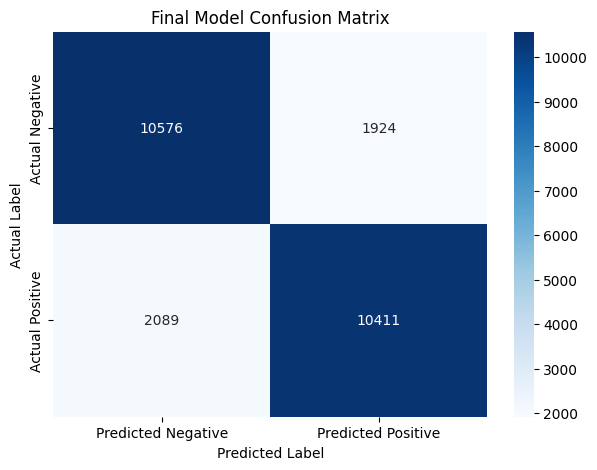

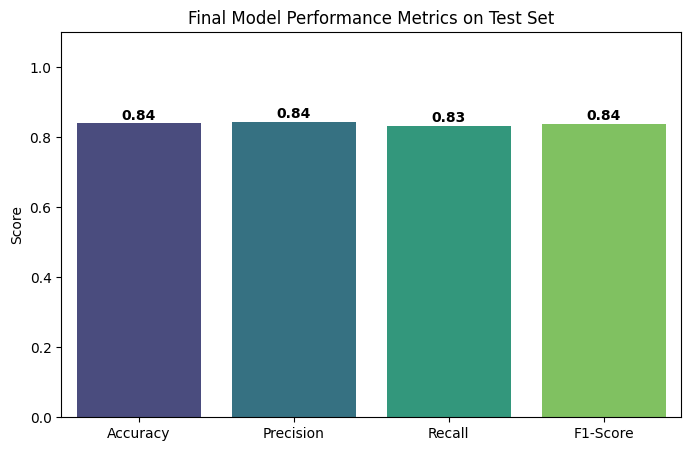

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# --- Plot 1: Box Plot of CV Scores ---
# This plot shows the stability of your model.
# A small box means your model is very consistent.
cv_metrics_df = pd.DataFrame({
    'Accuracy': fold_accuracies,
    'Precision': fold_precisions,
    'Recall': fold_recalls,
    'F1-Score': fold_f1s
})


print("-------------------------------------------------------------------")

# ==============================================================================
# PART 2: FINAL TRAINING AND TESTING (To get final report)
# ==============================================================================
print("\n--- Starting Final Model Training ---")

# Now that we're confident, train the model ONE time on ALL training data
classsifier.fit(X_train, y_train)

# Now, predict ONE time on the unseen test set
final_predictions = classsifier.predict(X_test)

# Get the final scores
final_acc = accuracy_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_recall = recall_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print("\n--- Final Test Set Results ---")
print(classification_report(y_test, final_predictions))

# --- Plot 2: Final Confusion Matrix ---
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(7, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Predicted Negative', 'Predicted Positive'],
    yticklabels=['Actual Negative', 'Actual Positive']
)
plt.title('Final Model Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Plot 3: Final Scores Bar Chart ---
final_metrics_dict = {
    'Accuracy': final_acc,
    'Precision': final_precision,
    'Recall': final_recall,
    'F1-Score': final_f1
}
metric_names = list(final_metrics_dict.keys())
metric_values = list(final_metrics_dict.values())

plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=metric_names, y=metric_values, palette='viridis')
for i, v in enumerate(metric_values):
    barplot.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.title('Final Model Performance Metrics on Test Set')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.show()